In [2]:
# import libraries
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine, euclidean
import numpy as np
import matplotlib.pyplot as plt

2025-03-07 19:46:13.886818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load original image to use as prediction base for forward pass
img_path = './images/justice_league.png'
base_img = load_img(img_path, target_size=(224, 224))

# convert image to numpy array
base_img = img_to_array(base_img)

In [4]:
# function to simulate image transformations expected in the wild by applying various perturbations
def ptb_apply(image):
    # convert image array to PIL image object
    pil_img = Image.fromarray(image.astype('uint8'))
    # initialize empty list to store images with each perturbation applied
    ptb_img_list = []
    
    # increase image brightness
    bright_img = ImageEnhance.Brightness(pil_img).enhance(2)
    ptb_img_list.append(np.array(bright_img))
    
    # increase image contrast
    contrast_img = ImageEnhance.Contrast(pil_img).enhance(2)
    ptb_img_list.append(np.array(contrast_img))
    
    # apply gaussian blur
    gaussian_blur_img = pil_img.filter(ImageFilter.GaussianBlur(radius=2))
    ptb_img_list.append(np.array(gaussian_blur_img))
    
    # apply defocus blur using large kernel gaussian blur
    defocus_blur_img = pil_img.filter(ImageFilter.GaussianBlur(radius=10))
    ptb_img_list.append(np.array(defocus_blur_img))
    
    # apply fog blur by decreasing contrast and adding gaussian blur
    fog_img = ImageEnhance.Contrast(pil_img).enhance(0.7)
    fog_img = fog_img.filter(ImageFilter.GaussianBlur(radius=2))
    ptb_img_list.append(np.array(fog_img))
    
    # rotate image by 90 degrees
    rotated_img = pil_img.rotate(90, expand=True)
    ptb_img_list.append(np.array(rotated_img))
    
    # flip image horizontally
    horizontal_img = ImageOps.mirror(pil_img)
    ptb_img_list.append(np.array(horizontal_img))
    
    # flip image vertically 
    vertical_img = ImageOps.flip(pil_img)
    ptb_img_list.append(np.array(vertical_img))
    
    # generate random noise and add to image
    rand_noise = np.random.randint(0, 50, image.shape, dtype='uint8')
    # clip random noise to ensure pixel values are valid
    random_noise_image = np.clip(image + rand_noise, 0, 255)
    ptb_img_list.append(random_noise_image)
    
    # generate salt and pepper noise and add to image
    sp_image = image.copy()
    # extract image dimensions
    h, w, c = sp_image.shape
    # compute number of noisy pixels
    pixels = int(h * w * 0.05)
    # loop to iterate noisy pixels to add salt or pepper noise 
    for _ in range(pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() < 0.5:
            # add black/pepper noise
            sp_image[row, col] = [0, 0, 0] 
        else:
            # add white/salt noise
            sp_image[row, col] = [255, 255, 255]
    ptb_img_list.append(sp_image)
    
    # return list of images with each perturbation applied
    return ptb_img_list

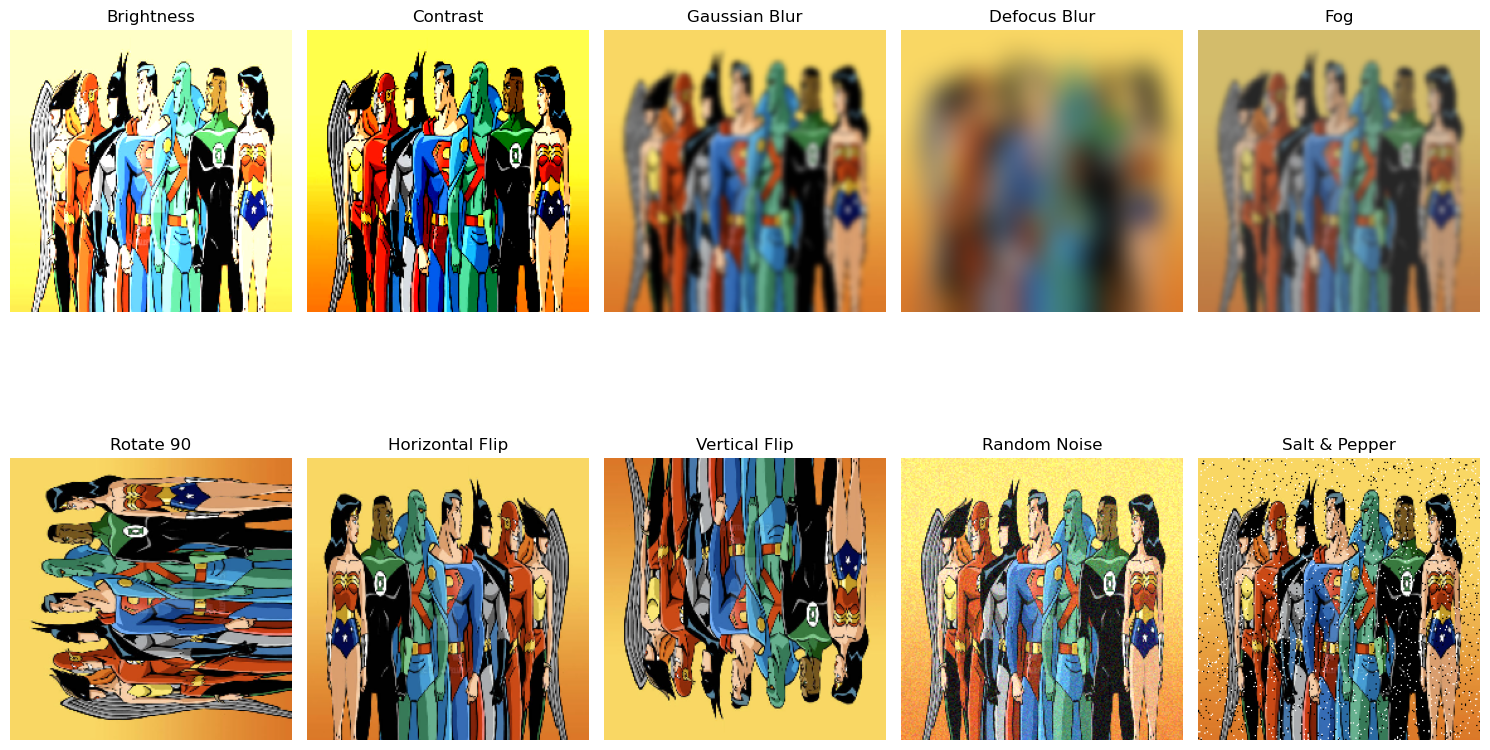

In [5]:
# call ptb_apply function to apply perturbations to base image
ptb_images = ptb_apply(base_img)

# initialize list of perturbation titles for plotting
ptb_applied = ['Brightness', 'Contrast', 'Gaussian Blur', 'Defocus Blur', 'Fog', 
               'Rotate 90', 'Horizontal Flip', 'Vertical Flip', 'Random Noise', 'Salt & Pepper']

# visualize images with perturbations applied
plt.figure(figsize=(15, 10))
for i, img in enumerate(ptb_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img.astype('uint8'))
    plt.title(f'{ptb_applied[i]}')
    plt.axis('off')

plt.savefig("./images/perturbated_images.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [6]:
# initialize image classification models
vgg16_mod = VGG16(weights='imagenet')
resnet50_mod = ResNet50(weights='imagenet')
densenet121_mod = DenseNet121(weights='imagenet')
efficientnetb0_mod = EfficientNetB0(weights='imagenet')

In [7]:
# function to generate predictions and decode predicted output
def predict(image, cnn):
    # preprocess image before prediction
    preprocessed_image = preprocess_input(np.expand_dims(image, axis=0))
    # generate prediction on current image with current image model
    predictions = cnn.predict(preprocessed_image)
    # return decoded output
    return decode_predictions(predictions, top=1)[0][0][1]

# generate baseline predictions of original image for each model
vgg16_pred = predict(base_img, vgg16_mod)
resnet50_pred = predict(base_img, resnet50_mod)
densenet121_pred = predict(base_img, densenet121_mod)
efficientnetb0_pred = predict(base_img, efficientnetb0_mod)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [8]:
# function to calculate consistency score for each image model
def consistency(base_pred, ptb_imgs, cnn):
    # initialize number of correct predictions as 0
    correct_preds = 0
    # loop to generate predictions for all perturbated images
    for img in ptb_imgs:
        ptb_pred = predict(img, cnn)
        # check if new perturbation prediction is consistent with original
        if ptb_pred == base_pred:
            # increase count of correct predictions by 1 if consistent
            correct_preds += 1
    # calculate proportion of consistent predictions
    score = correct_preds / len(ptb_imgs)
    return score

# call consistency function to score each model's robustness
vgg16_score = consistency(vgg16_pred, ptb_images, vgg16_mod)
resnet50_score = consistency(resnet50_pred, ptb_images, resnet50_mod)
densenet121_score = consistency(densenet121_pred, ptb_images, densenet121_mod)
efficientnetb0_score = consistency(efficientnetb0_pred, ptb_images, efficientnetb0_mod)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st

In [9]:
# function to extract feature maps for each model
def extract_features(model):
    # create new model to extract feature maps using original model input
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
    # get feature maps for original and perturbated images
    features = feature_extractor.predict(np.expand_dims(base_img, axis=0))
    ptb_features = [feature_extractor.predict(np.expand_dims(img, axis=0)) for img in ptb_images]
    return features, ptb_features 

In [10]:
# function to evaluate feature map similarity using Cosine distance
def cosine_eval(base_features, ptb_features):
    # calculate Cosine distance between features
    cosine_dist = [1 - cosine(base_features.flatten(), feature.flatten()) for feature in ptb_features]
    # calculate average Cosine distance across all perturbations
    avg_cosine_dist = np.mean(cosine_dist)
    return avg_cosine_dist

In [11]:
# function to evaluate feature map similarity using Euclidean distance
def euclidean_eval(base_features, ptb_features):
    # calculate maximum Euclidean distance between features
    max_dist = np.linalg.norm(np.ones_like(base_features.flatten()) * (base_features.max() - base_features.min()))
    # calculate normalized Euclidean distance between features
    euclidean_dist = [1 - (euclidean(base_features.flatten(), feature.flatten()) / max_dist) for feature in ptb_features]
    # calculate average Euclidean distance across all perturbations
    avg_euclidean_dist = np.mean(euclidean_dist)
    return avg_euclidean_dist

In [12]:
# extract feature maps for each model
vgg_16_features, vgg_16_ptb_features = extract_features(vgg16_mod)
resnet50_features, resnet50_ptb_features = extract_features(resnet50_mod)
densenet121_features, densenet121_ptb_features = extract_features(densenet121_mod)
efficientnetb0_features, efficientnetb0_ptb_features = extract_features(efficientnetb0_mod)

# calculate average Cosine similarity for each model
vgg16_cosine = cosine_eval(vgg_16_features, vgg_16_ptb_features)
resnet50_cosine = cosine_eval(resnet50_features, resnet50_ptb_features)
densenet121_cosine = cosine_eval(densenet121_features, densenet121_ptb_features)
efficientnetb0_cosine = cosine_eval(efficientnetb0_features, efficientnetb0_ptb_features)

# calculate average Euclidean similarity for each model
vgg16_euclidean = euclidean_eval(vgg_16_features, vgg_16_ptb_features)
resnet50_euclidean = euclidean_eval(resnet50_features, resnet50_ptb_features)
densenet121_euclidean = euclidean_eval(densenet121_features, densenet121_ptb_features)
efficientnetb0_euclidean = euclidean_eval(efficientnetb0_features, efficientnetb0_ptb_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━

In [13]:
# VGG16 consistency score, Cosine similarity, and Euclidean similarity
print("\n-----------------------------------------------------------------")
print("VGG16 Results:\n")
print(f"VGG16 Prediction Consistency = {vgg16_score * 100}%\n")
print(f"VGG16 Average Cosine Similarity = {vgg16_cosine}\n")
print(f"VGG16 Average Euclidean Similarity = {vgg16_euclidean}\n")

# ResNet50 consistency score, Cosine similarity, and Euclidean similarity
print("\n-----------------------------------------------------------------")
print("ResNet50 Results:\n")
print(f"ResNet50 Prediction Consistency = {resnet50_score * 100}%\n")
print(f"ResNet50 Average Cosine Similarity = {resnet50_cosine}\n")
print(f"ResNet50 Average Euclidean Similarity = {resnet50_euclidean}\n")

# DenseNet121 consistency score, Cosine similarity, and Euclidean similarity
print("\n-----------------------------------------------------------------")
print("DenseNet121 Results:\n")
print(f"DenseNet121 Prediction Consistency = {densenet121_score * 100}%\n")
print(f"DenseNet121 Average Cosine Similarity = {densenet121_cosine}\n")
print(f"DenseNet121 Average Euclidean Similarity = {densenet121_euclidean}\n")

# EfficientNetB0 consistency score, Cosine similarity, and Euclidean similarity
print("\n-----------------------------------------------------------------")
print("EfficientNetB0 Results:\n")
print(f"EfficientNetB0 Prediction Consistency = {efficientnetb0_score * 100}%\n")
print(f"EfficientNetB0 Average Cosine Similarity = {efficientnetb0_cosine}\n")
print(f"EfficientNetB0 Average Euclidean Similarity = {efficientnetb0_euclidean}\n")


-----------------------------------------------------------------
VGG16 Results:

VGG16 Prediction Consistency = 50.0%

VGG16 Average Cosine Similarity = 0.6233785261135163

VGG16 Average Euclidean Similarity = 0.9048854978961408


-----------------------------------------------------------------
ResNet50 Results:

ResNet50 Prediction Consistency = 0.0%

ResNet50 Average Cosine Similarity = 0.46675479410971843

ResNet50 Average Euclidean Similarity = 0.9501229276166852


-----------------------------------------------------------------
DenseNet121 Results:

DenseNet121 Prediction Consistency = 90.0%

DenseNet121 Average Cosine Similarity = 0.6502292857260189

DenseNet121 Average Euclidean Similarity = 0.9368081305226225


-----------------------------------------------------------------
EfficientNetB0 Results:

EfficientNetB0 Prediction Consistency = 20.0%

EfficientNetB0 Average Cosine Similarity = 0.30235306475427437

EfficientNetB0 Average Euclidean Similarity = 0.8991176408875168
